<a href="https://colab.research.google.com/github/nujudaly/T5/blob/main/Nujud_Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [63]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import  numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df = pd.read_csv('/content/drive/MyDrive/Twaiq/Traffic Data.csv', parse_dates=['date_time'], index_col=['date_time'])
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [26]:
df['date'] = df.index.date
df['time'] = df.index.time

In [27]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date,time
date_time,,,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27,01:00:00
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06,23:00:00
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25,18:00:00
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09,22:00:00
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09,15:00:00


In [28]:
df['Time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [29]:
def specific_data(traffic, start, end):
    traffic_data = df[df['traffic_volume'] == traffic]
    date_filtered_data = traffic_data[(traffic_data.index > start) & (traffic_data.index < end)]
    return date_filtered_data

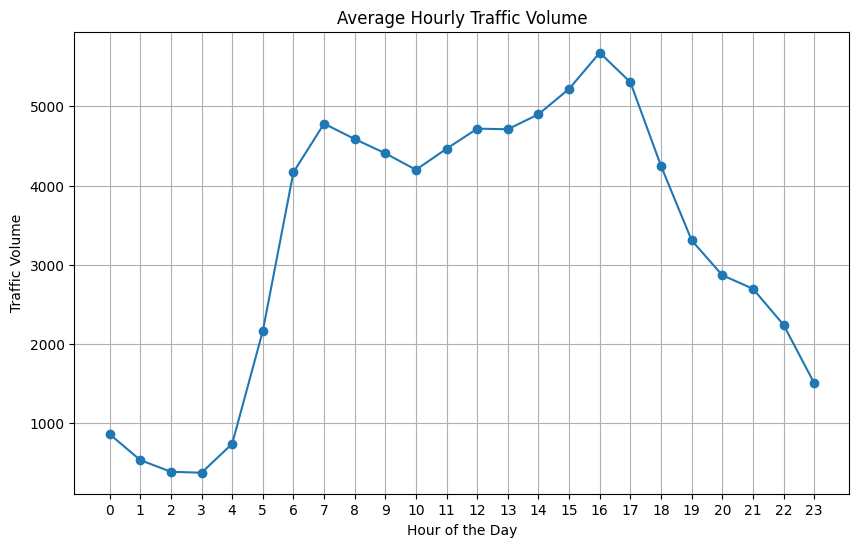

In [30]:
hourly_data = df.groupby('Time')['traffic_volume'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_data.index, hourly_data.values, marker='o')
plt.title('Average Hourly Traffic Volume')
plt.xlabel('Hour of the Day')
plt.ylabel('Traffic Volume')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [31]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date,0
time,0
Time,0


In [32]:
df.isna().sum().dropna()
df.dropna(inplace=True)

In [33]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date,0
time,0
Time,0


In [34]:
df.drop_duplicates(inplace=True)

In [35]:
df.resample('H')

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [36]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)

In [37]:
traffic_volume_diff = df['traffic_volume'].value_counts()

In [38]:
prev_traffic_volume_diff = df['prev_traffic_volume']

In [39]:
#df['day'] = df['date_time'].dt.day


In [40]:
#df['day_of_week'] = df['date_time'].dt.dayofweek


In [ ]:
#df['Month'] = df['date_time'].dt.month


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [41]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['traffic_volume'].values.reshape(-1, 1))

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [42]:

def create_dataset(data, time_steps=1):
    X, Y = [], []
    for i in range(len(data)-time_steps-1):
        z = data[i:(i+time_steps), 0]
        X.append(z)
        Y.append(data[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 24

X, Y = create_dataset(scaled_data, time_steps)

X = X.reshape(X.shape[0], X.shape[1], 1)

training_size = int(len(X) * 0.8)
X_train, X_test = X[:training_size], X[training_size:]
Y_train, Y_test = Y[:training_size], Y[training_size:]

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [73]:
#Choosing LSTM as the first model


model = Sequential()

model.add(LSTM(32, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')



### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [74]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping])


Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.0214 - val_loss: 0.0138
Epoch 2/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 3/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 4/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 5/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 6/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 7/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 8/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 9/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0143 - val_loss: 0.0138
Epoch 10/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.0143 - val_loss: 0.0138
Epoch 11/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.0143 - val_loss: 0.0138


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [75]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

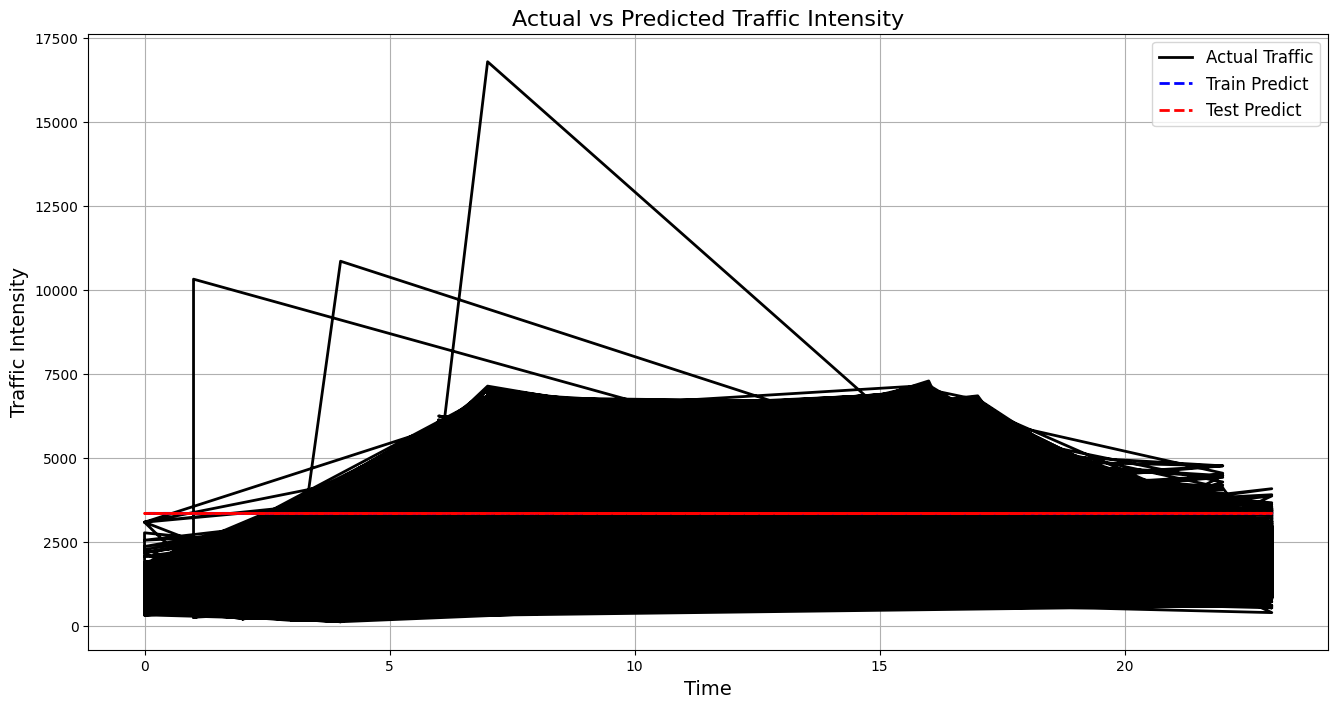

In [76]:
plt.figure(figsize=(16, 8))

plt.plot(df['Time'], df['traffic_volume'], label='Actual Traffic', color='black', linewidth=2)

plt.plot(df['Time'][time_steps+1:len(train_predict)+time_steps+1], train_predict,
         label='Train Predict', color='blue', linestyle='--', linewidth=2)

plt.plot(df['Time'][len(train_predict)+time_steps+1:], test_predict,
         label='Test Predict', color='red', linestyle='--', linewidth=2)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Traffic Intensity', fontsize=14)
plt.title('Actual vs Predicted Traffic Intensity', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [77]:
train_r2 = r2_score(df['traffic_volume'][time_steps+1:len(train_predict)+time_steps+1], train_predict)
train_mse = mean_squared_error(df['traffic_volume'][time_steps+1:len(train_predict)+time_steps+1], train_predict)


test_r2 = r2_score(df['traffic_volume'][len(train_predict)+time_steps+1:], test_predict)
test_mse = mean_squared_error(df['traffic_volume'][len(train_predict)+time_steps+1:], test_predict)


print(f"Training R²: {train_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing R²: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Training R²: -0.0015
Training MSE: 3933345.4207
Testing R²: -0.0000
Testing MSE: 3835400.5097


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [78]:
model = Sequential()


model.add(SimpleRNN(32, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(1024, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dense(1))



model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - loss: 3.6147 - val_loss: 0.0140
Epoch 2/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - loss: 0.0180 - val_loss: 0.0143
Epoch 3/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.0163 - val_loss: 0.0139
Epoch 4/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - loss: 0.0165 - val_loss: 0.0138
Epoch 5/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - loss: 0.0177 - val_loss: 0.0141
Epoch 6/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0190 - val_loss: 0.0161
Epoch 7/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 0.0202 - val_loss: 0.0138
Epoch 8/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0228 - val_loss: 0.0143
Epoch 9/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - loss: 0.0238 - val_loss: 0.0146
Epoch 10/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0262 - val_loss: 0.0158
Epoch 11/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.0250 - val_loss: 0.0215
Epoch 12/100
499/49

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [79]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


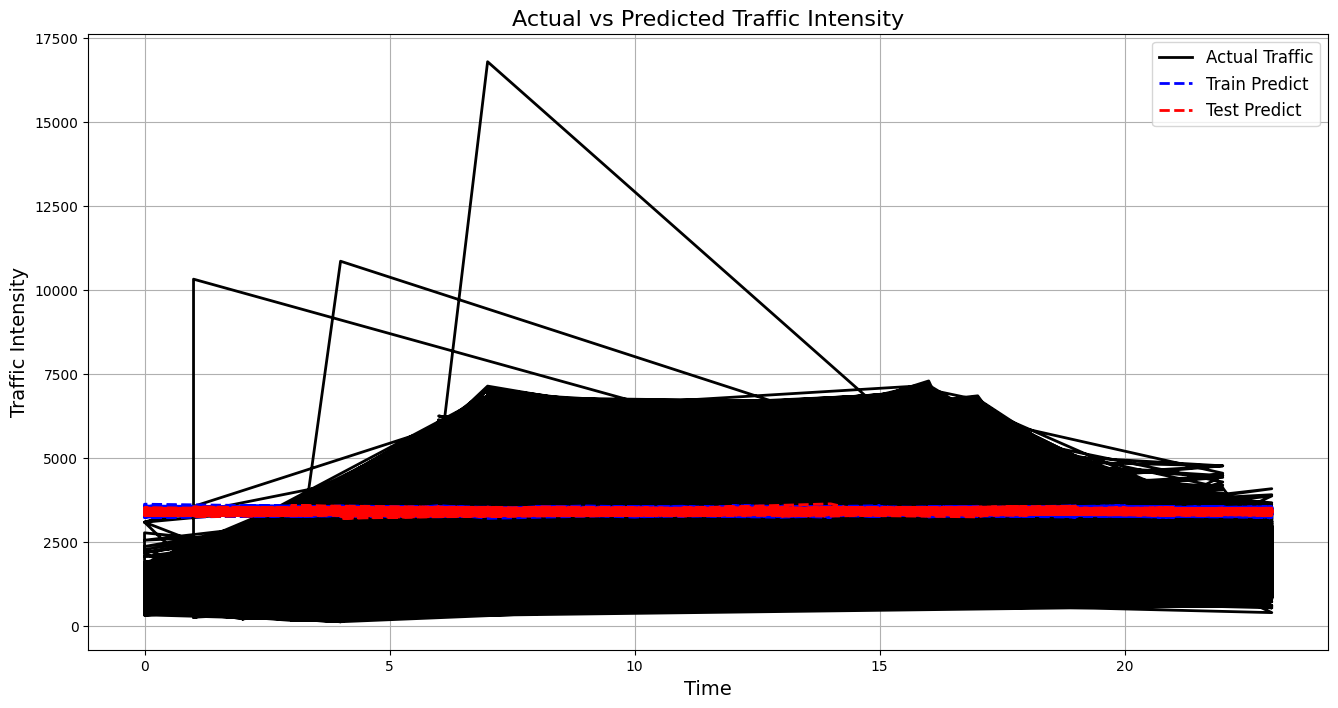

In [80]:
plt.figure(figsize=(16, 8))

plt.plot(df['Time'], df['traffic_volume'], label='Actual Traffic', color='black', linewidth=2)

plt.plot(df['Time'][time_steps+1:len(train_predict)+time_steps+1], train_predict,
         label='Train Predict', color='blue', linestyle='--', linewidth=2)

plt.plot(df['Time'][len(train_predict)+time_steps+1:], test_predict,
         label='Test Predict', color='red', linestyle='--', linewidth=2)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Traffic Intensity', fontsize=14)
plt.title('Actual vs Predicted Traffic Intensity', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [81]:
train_r2 = r2_score(df['traffic_volume'][time_steps+1:len(train_predict)+time_steps+1], train_predict)
train_mse = mean_squared_error(df['traffic_volume'][time_steps+1:len(train_predict)+time_steps+1], train_predict)


test_r2 = r2_score(df['traffic_volume'][len(train_predict)+time_steps+1:], test_predict)
test_mse = mean_squared_error(df['traffic_volume'][len(train_predict)+time_steps+1:], test_predict)


print(f"Training R²: {train_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing R²: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Training R²: -0.0058
Training MSE: 3950225.1827
Testing R²: -0.0013
Testing MSE: 3840321.8604


## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:


    Data Preprocessing: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?

    In handeling missing data I used the method .dropna(), the missing values were 20 out of 19980, so it was not harmful to drop them as the best practice.

    Feature Engineering: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
    yes I did seprate the date_time colomn into two components: date: the date of the day, and time: the hours in the format: '%H, %M, %S, which was usful to let me see the traffic volumes and plot it at an hourly frequency.

    Model Architecture: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
    In LSTM I inteded to add more layers because of my experimenting with less layers that perfromed poorly, however, regarding large size of data it is best to design more complex layers: I started with 32 up to 1024 to habdel the complexity of the data in the Dense layer I dropped 30% of data randomly to assure there is not an overfitting, and outputed a single output('traffic prediction in hrs frequency')

    Training Process: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
    Yes, I choose each batch to be 32 in order to make sure the model training accuracy, choosing 100 epchos but the training process was not performing well, which needs more experimnting from my side, RNN was performing slightly better than LSTM but both experienced early stopping which indicate high loss percentage which is not fortunate, if there was more time I will make sure the model training will go smooth.
    Loss Function and Metrics: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting? MSE because it puts more peneality in high error weights, and is differentiable making it more suitbale for timeseries.
    Model Tuning (If Done): Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
    the dropout method helped with making the perfromance better, there is not so much difference between the training and loss regradless of the unfortunate training process.
    Overfitting and Underfitting: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues? Can say it experienced an overfitting on LSTM side, howerever it needs more improvement in the training process.
    Future Improvements: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.
    I will add more layers and do more hyperparameter tuning.